# Transfer Learning using tensorflow 1: Feature Extraction

advantages
1. architecture which is already proven to work on problem similar to ours

## Downloading the data and becoming one with it

In [ ]:
# get data (10% of 10 food classes from 101 food)
import zipfile

!wget !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-06-27 15:48:33--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2021-06-27 15:48:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 108.177.98.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   177MB/s    in 0.9s    

2021-06-27 15:48:34 (177 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]

FINISHED --2021-06-27 15:48:34--
Total wall clock time: 1.2s
Downloaded: 1 files, 161M in 0.9s (177 MB/s)


## Creating data loaders

In [ ]:
#setup data input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

* Experiment tracking with TensorBoard - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [ ]:
#create tensorboard callbak

import datetime

def create_tensorflow_callback(dir_name,experiment_name):
  log_dir = dir_name+'/'+experiment_name+'/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
  print("Saving tensorboard log file to : ",log_dir)
  return tensorboard_callback

## Creating models using Tensorflowhub


Using the model
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1


In [ ]:
#lets compare the two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [ ]:
#lets make a crete_model() function 
def create_model(model_url,num_classes=10):
  #download the pretrained model
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  #creating the model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])

  return model

###Creating Resnet Tensorflow hub feature extraction model

In [ ]:
resnet_model = create_model(resnet_url,num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data_10_percent,
                 validation_steps=len(test_data_10_percent),
                 callbacks=[create_tensorflow_callback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet50v2")])

Saving tensorboard log file to :  tensorflow_hub/resnet50v2/20210627-164703
Epoch 1/5
24/24 [==============================] - 18s 781ms/step - loss: 1.8737 - accuracy: 0.3853 - val_loss: 1.1888 - val_accuracy: 0.6156
Epoch 2/5
24/24 [==============================] - 15s 664ms/step - loss: 0.8878 - accuracy: 0.7360 - val_loss: 0.8385 - val_accuracy: 0.7248
Epoch 3/5
24/24 [==============================] - 15s 660ms/step - loss: 0.6075 - accuracy: 0.8227 - val_loss: 0.7395 - val_accuracy: 0.7528
Epoch 4/5
24/24 [==============================] - 16s 667ms/step - loss: 0.4708 - accuracy: 0.8960 - val_loss: 0.6828 - val_accuracy: 0.7792
Epoch 5/5
24/24 [==============================] - 16s 673ms/step - loss: 0.3764 - accuracy: 0.9267 - val_loss: 0.6602 - val_accuracy: 0.7788


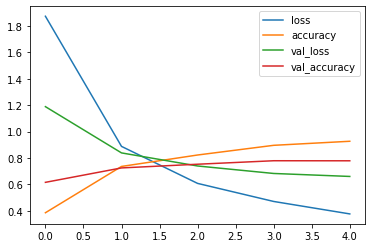

In [ ]:
import pandas as pd
pd.DataFrame(resnet_history.history).plot()

That is dope that too in 10% of the origincal dataset

In [ ]:
#Function to plot oue loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  epochs = range(len(history.history["loss"]))

  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()
  plt.figure()
  plt.plot(epochs,accuracy,label="training_Accuracy")
  plt.plot(epochs,val_accuracy,label="val_Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()
  

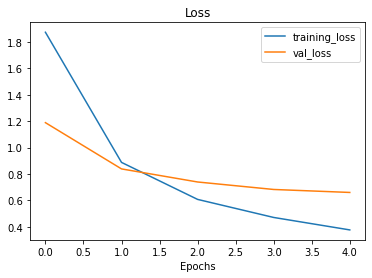

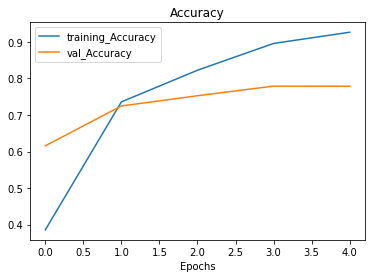

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNet80 tensorflow HUb extraction model

In [ ]:
efficientnet_model = create_model(efficientnet_url)


In [ ]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=10, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorflow_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetB0")])


Saving tensorboard log file to :  tensorflow_hub/efficientnetB0/20210627-172729
Epoch 1/10
24/24 [==============================] - 29s 1s/step - loss: 0.4792 - accuracy: 0.8773 - val_loss: 0.5104 - val_accuracy: 0.8640
Epoch 2/10
24/24 [==============================] - 15s 625ms/step - loss: 0.3829 - accuracy: 0.9213 - val_loss: 0.4734 - val_accuracy: 0.8700
Epoch 3/10
24/24 [==============================] - 15s 626ms/step - loss: 0.3238 - accuracy: 0.9360 - val_loss: 0.4476 - val_accuracy: 0.8716
Epoch 4/10
24/24 [==============================] - 15s 623ms/step - loss: 0.2826 - accuracy: 0.9520 - val_loss: 0.4304 - val_accuracy: 0.8768
Epoch 5/10
24/24 [==============================] - 14s 617ms/step - loss: 0.2465 - accuracy: 0.9573 - val_loss: 0.4194 - val_accuracy: 0.8792
Epoch 6/10
24/24 [==============================] - 14s 622ms/step - loss: 0.2194 - accuracy: 0.9667 - val_loss: 0.4115 - val_accuracy: 0.8792
Epoch 7/10
24/24 [==============================] - 14s 619ms/ste

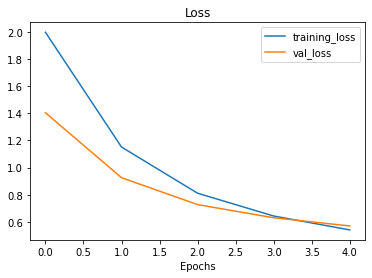

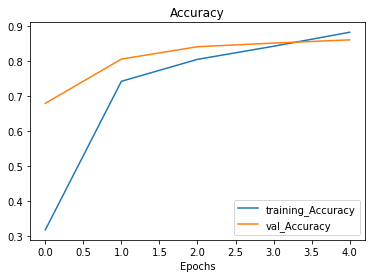

In [ ]:
plot_loss_curves(efficientnet_history)

EfficientNet op in the chat 

##Different types of transfer learning
* "As is" transferlearning model- using model with no changes what so ever eg using ImageNet model 
* "Feature extraction" use the prelearned patterns of an existing model eg EffiecientNetB0 trained on ImageNet and adjust the output layer for our own problem
* "Fine_tuning" using the prelearned patterns of an existing model and fine tune many or all of the undelying layers(including new output layers)